# Customer churn prediction 
## First contact with data

First let's import all the libraries we're going to use in this part of the project

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')

In [88]:
def kdeplotComparision(data, x, hue):
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set palette
    palette = ['darkblue', 'darkred']
    
    # Plot KDEs
    for i, group in enumerate(data.groupby(hue)):
        label = 'Customer' if i == 0 else 'Exited'
        sns.kdeplot(data=group[1], x=x, fill=True, alpha=.45,
                    linewidth=2, common_norm=False, common_grid=True,
                    color=palette[i], label=label, ax=ax)
        
    sns.despine()
    
    return fig, ax




def multi_barplot(data, target, feat):
    total = data[feat].value_counts()
    churn = data.groupby(feat)[target].sum()

    churn_rate = (churn / total) * 100

    data_plot = pd.concat([total.rename('Total'), churn.rename('Churned'), churn_rate.rename('%Churn')], axis=1)
    data_plot.reset_index(inplace=True)


    plt.figure(figsize=(10,6))
    sns.barplot(data=data_plot, x='index', y='Total', color='darkblue', label='Total', alpha=0.85)
    sns.barplot(data=data_plot, x='index', y='Churned', color='darkred', label='Churned', alpha=0.85)
        
    for i, row in data_plot.iterrows():
            plt.annotate(f"{row['%Churn']:.1f}% of churn", 
                        xy=(i, row['Churned'] + row['Total'] * 0.01),
                        ha='center', va='bottom', fontsize=10, fontweight='bold')    

    plt.title(f'Churned Customers by: {feat}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('')
    plt.xticks(fontsize=12)
    plt.ylabel('Number of Customers', fontsize=14, fontweight='bold')
    plt.ylim(0, 5300)
    plt.grid(axis='y', linestyle='--', alpha=0.17)

    plt.legend(fontsize=12)

    sns.despine(right=True, top=True)

    plt.tight_layout()
    plt.show()
    
    
    
def binary_barplot(data, feat, target):
    total = data[feat].value_counts()
    churn = data.groupby(feat)[target].sum()
    churn_rate = (churn / total) * 100

    data_plot = pd.concat([total.rename('Total'), churn.rename('Churned'), churn_rate.rename('%Churn')], axis=1)
    data_plot.reset_index(inplace=True)
    data_plot = data_plot.sort_values('index')

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=data_plot, x='index', y='Total', color='darkblue', label='Total', alpha=0.85)
    churn_bars = sns.barplot(data=data_plot, x='index', y='Churned', color='darkred', label='Churned', alpha=0.85)

    for bar, churn_percent in zip(churn_bars.patches, data_plot['%Churn']):
        height = (churn_percent * 0.01) * bar.get_height()
        ax.annotate(f'{churn_percent:.1f}% of churn', (bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title(f'Total Number of People and Churned Customers by {feat}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('')
    plt.ylabel('Number of Customers', fontsize=14, fontweight='bold')
    plt.ylim(0, data_plot['Total'].max() + 500)  # Adjust the y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.17)
    plt.legend(fontsize=12)
    sns.despine(right=True, top=True)
    plt.tight_layout()
    plt.show()

Now we need to load the data, it's a .csv file.

In [89]:
data = pd.read_csv('../data/raw/Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [90]:
df = data.copy()

Let's do some exploratory analysis 

In [47]:
# Assuming you have a DataFrame named df
df.describe().round(2).applymap('{:.2f}'.format)


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [49]:
df.duplicated().value_counts()

False    10000
dtype: int64

In [50]:
data.shape

(10000, 14)

In [51]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

It is possible that this dataset was generated specifically for study purposes because it appears to be clean and does not have any inconsistencies such as outliers or missing values that need to be fixed.

Let's remove the columns we know won't be important for the analysis
 - RowNumber
 - CustomerID
 - Surname
 

In [52]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [53]:
data_plot = df.copy()

encoder = LabelEncoder()

data_plot['Geography'] = encoder.fit_transform(data_plot['Geography'])
data_plot['Gender'] = encoder.fit_transform(data_plot['Gender'])
data_plot.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


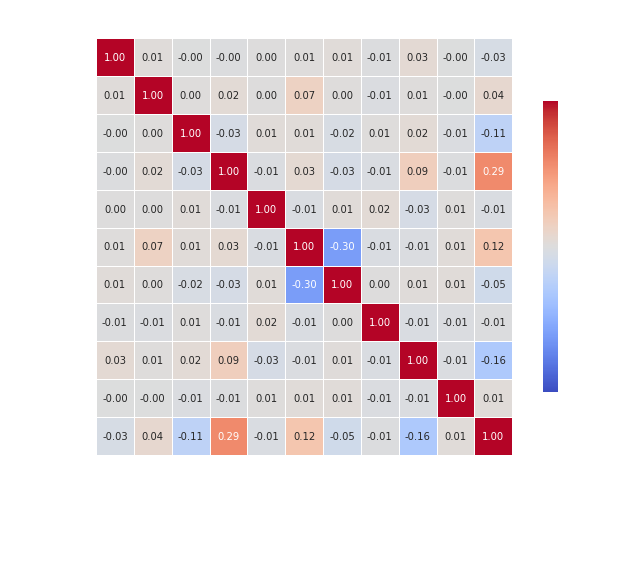

In [54]:
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(data=data_plot.corr(), cmap='coolwarm', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .7}, vmin=-0.5, vmax=0.5)

# Customize axes labels and title
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)

# Center x-tick labels
plt.xticks(np.arange(0.5, len(df.columns)+0.5), df.columns, ha='center', fontsize=12)

# Customize colorbar label
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Correlation Coefficient', fontsize=14, fontweight='bold', labelpad=10)

plt.tight_layout()
plt.show()


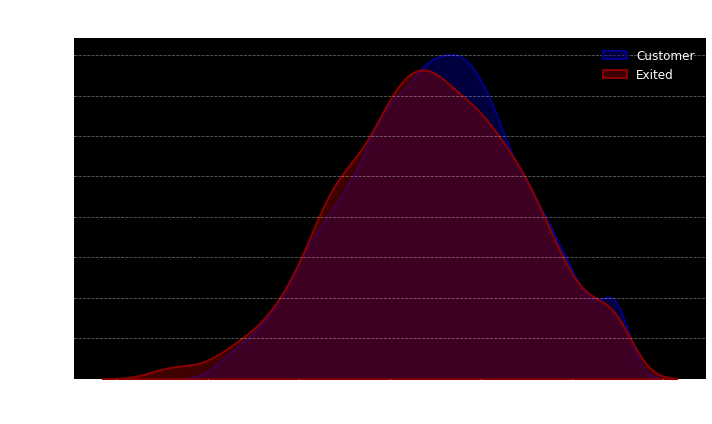

In [55]:
fig, ax = kdeplotComparision(data=df, x='CreditScore', hue='Exited')

# Add title and axes labels
ax.set_title('Credit Score Distribution by Churn', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Credit Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

# Set legend
ax.legend(fontsize=12, frameon=False)

# Set ticks and grid
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.grid(axis='x', visible=False)

# Remove spines
sns.despine(left=True, bottom=True)


# Show plot
plt.tight_layout()
plt.show()

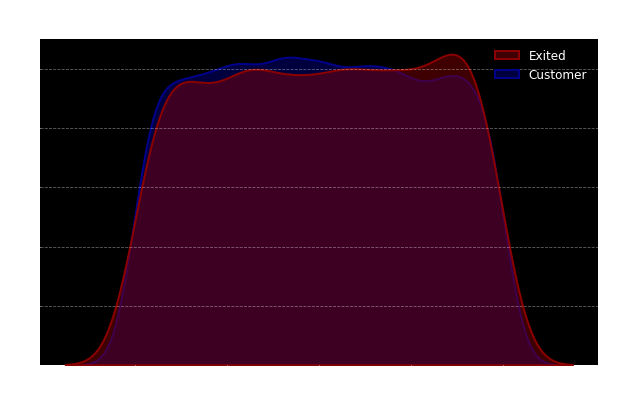

In [56]:
fig, ax = kdeplotComparision(data=df, x='EstimatedSalary', hue='Exited')

# Add title and axes labels
ax.set_title('Balance Distribution by Churn', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Balance', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

# Set legend
ax.legend(fontsize=12, frameon=False)

# Set ticks and grid
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.grid(axis='x', visible=False)

# Remove spines
sns.despine(left=True, bottom=True)

# Move second legend entry to back
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + handles[:1]
labels = labels[1:] + labels[:1]
ax.legend(handles, labels, fontsize=12, frameon=False)

# Show plot
plt.show()

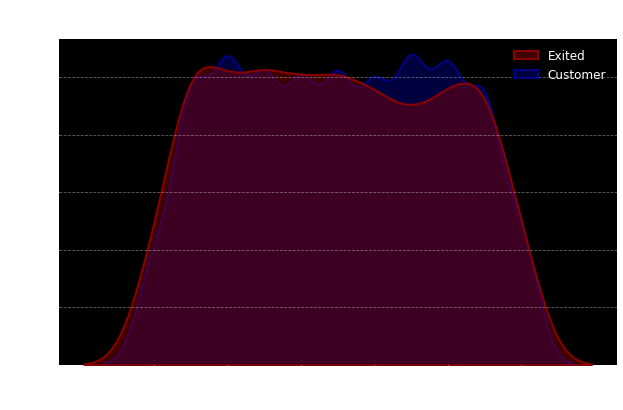

In [57]:
fig, ax = kdeplotComparision(data=df, x='Tenure', hue='Exited')

# Add title and axes labels
ax.set_title('Tenure Distribution by Churn', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Tenure', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

# Set legend
ax.legend(fontsize=12, frameon=False)

# Set ticks and grid
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.grid(axis='x', visible=False)

# Remove spines
sns.despine(left=True, bottom=True)

# Move second legend entry to back
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + handles[:1]
labels = labels[1:] + labels[:1]
ax.legend(handles, labels, fontsize=12, frameon=False)

# Show plot
plt.show()

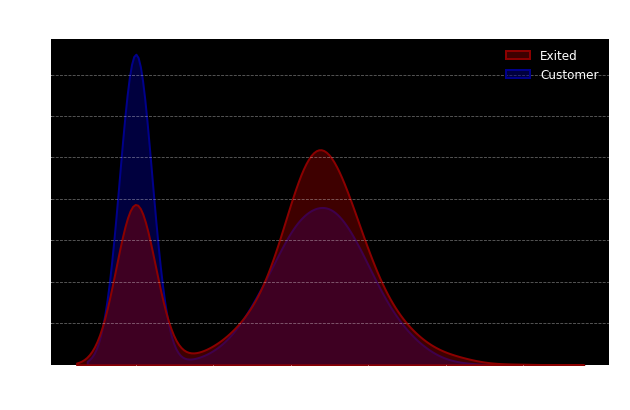

In [58]:
fig, ax = kdeplotComparision(data=df, x='Balance', hue='Exited')

# Add title and axes labels
ax.set_title('Balance Distribution by Churn', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Balance', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

# Set legend
ax.legend(fontsize=12, frameon=False)

# Set ticks and grid
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.grid(axis='x', visible=False)

# Remove spines
sns.despine(left=True, bottom=True)

# Move second legend entry to back
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + handles[:1]
labels = labels[1:] + labels[:1]
ax.legend(handles, labels, fontsize=12, frameon=False)

# Show plot
plt.show()

In [59]:
zero_bal = (df[df['Balance'] == 0].shape[0] / df.shape[0]) * 100
zero_bal_churn = (df[df['Balance'] == 0]['Exited'].sum() / df[df['Balance'] == 0]['Exited'].count()*100).round(2)
print(f'We have {zero_bal}% of customers with Balance = 0')
print(f'In this cluster of customers, we have {zero_bal_churn}% of churn rate')

non_zero_bal = (df[df['Balance'] > 0].shape[0] / df.shape[0]) * 100
non_zero_bal_churn = (df[df['Balance'] > 0]['Exited'].sum() / df[df['Balance'] == 0]['Exited'].count()*100).round(2)
print(f'\nWe have {non_zero_bal}% of customers with Balance > 0')
print(f'In this cluster of customers, we have {non_zero_bal_churn}% of churn rate')

We have 36.17% of customers with Balance = 0
In this cluster of customers, we have 13.82% of churn rate

We have 63.83% of customers with Balance > 0
In this cluster of customers, we have 42.49% of churn rate


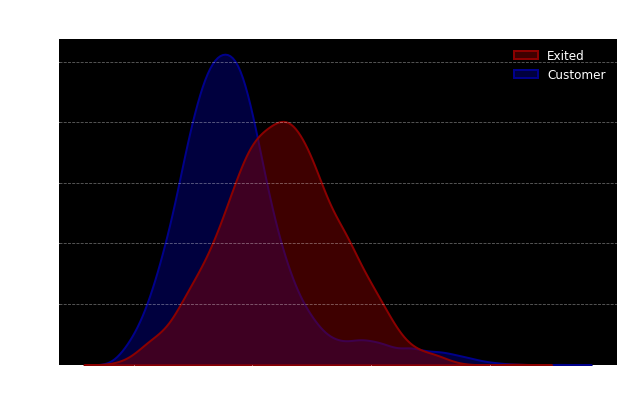

In [60]:
fig, ax = kdeplotComparision(data=df, x='Age', hue='Exited')

# Add title and axes labels
ax.set_title('Customer Age Distribution by Churn', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Age', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

# Set legend
ax.legend(fontsize=12, frameon=False)

# Set ticks and grid
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.grid(axis='x', visible=False)

# Remove spines
sns.despine(left=True, bottom=True)

# Move second legend entry to back
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + handles[:1]
labels = labels[1:] + labels[:1]
ax.legend(handles, labels, fontsize=12, frameon=False)

# Show plot
plt.show()


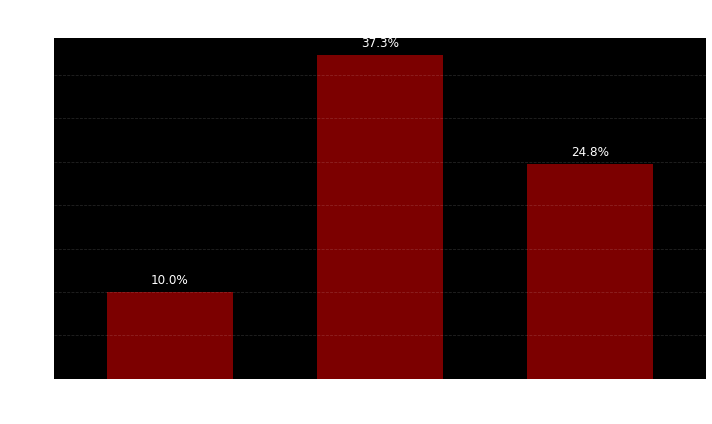

In [61]:
bins = [18, 39, 60, df['Age'].max()]
labels = ['18-39', '40-60', '60+']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Get churn rate
churn_rates = df.groupby('Age Group')['Exited'].mean()

# Create bar plot

ax = churn_rates.plot(kind='bar', color='darkred', alpha=0.9, width=0.6, figsize=(10, 6))

# Formatting chart
ax.set_title('Customer Churn Rates by Age Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Age Group', fontsize=14, fontweight='bold')
ax.set_ylabel('Churn Rate', fontsize=14, fontweight='bold')

# Set ticks and grid
ax.tick_params(labelsize=12, rotation=0, axis='x')
ax.grid(axis='y', linestyle='--', alpha=0.15)
ax.grid(axis='x', visible=False)

# Remove spines
sns.despine(left=True, bottom=True)

# Format y-axis tick labels as percentages
def format_percentages(tick_val, tick_pos):
    return '{:.0%}'.format(tick_val)

# Add percentage labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01, '{:.1%}'.format(height), ha='center', fontsize=12)

# Remove y-axis ticks
ax.tick_params(axis='y', left=False)

# Show plot
plt.tight_layout()
plt.show()



In [62]:
geo_total = data['Geography'].value_counts()
geo_churn = data.groupby('Geography')['Exited'].sum()

churn_rate = (geo_churn / geo_total) * 100


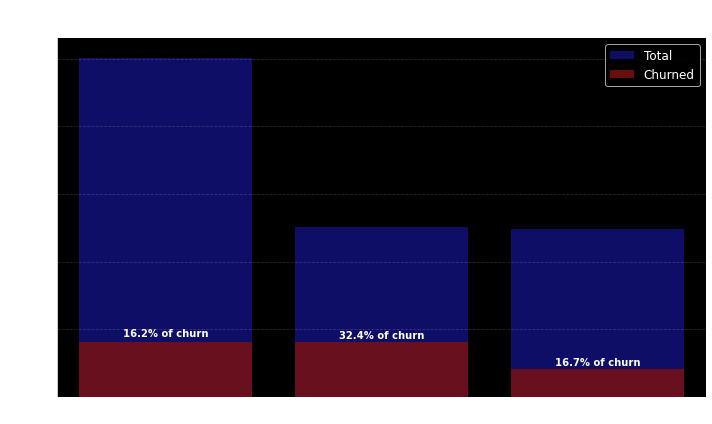

In [64]:
multi_barplot(data=df, target='Exited', feat='Geography')

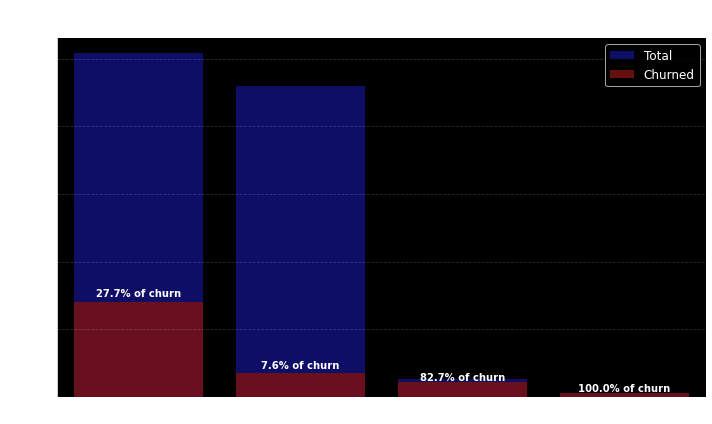

<Figure size 432x288 with 0 Axes>

In [69]:
multi_barplot(data=df, target='Exited', feat='NumOfProducts')
plt.tight_layout()
plt.show()

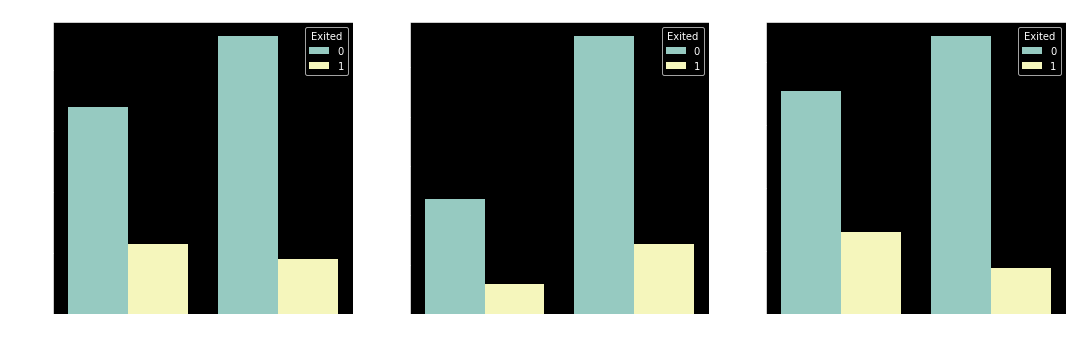

In [ ]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gender vs. Exited
sns.countplot(x='Gender', hue='Exited', data=df, ax=axes[0])
axes[0].set_title('Gender vs. Exited')

# Plot for HasCrCard vs. Exited
sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axes[1])
axes[1].set_title('HasCrCard vs. Exited')

# Plot for IsActiveMember vs. Exited
sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axes[2])
axes[2].set_title('IsActiveMember vs. Exited')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


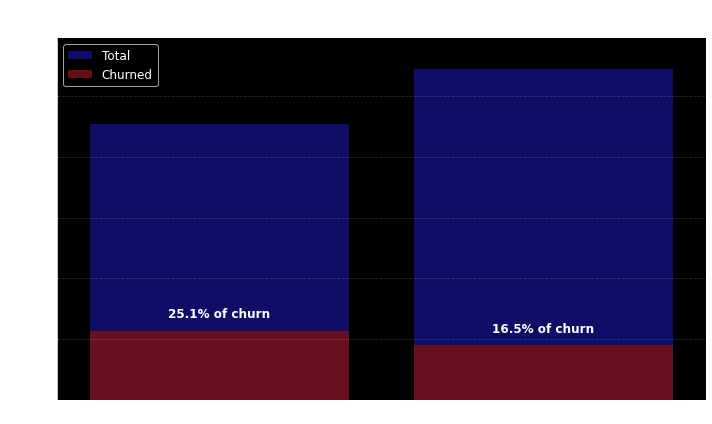

<Figure size 432x288 with 0 Axes>

In [70]:
binary_barplot(data=df, feat='Gender', target='Exited')
plt.tight_layout()
plt.show()

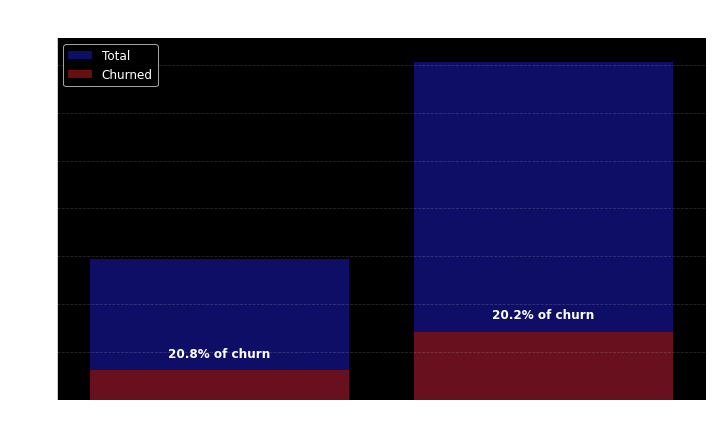

<Figure size 432x288 with 0 Axes>

In [66]:
binary_barplot(data=df, feat='HasCrCard', target='Exited')
plt.tight_layout()
plt.show()

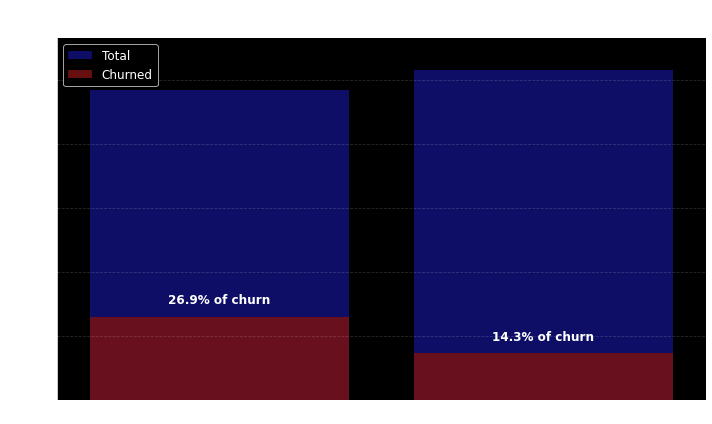

<Figure size 432x288 with 0 Axes>

In [71]:
binary_barplot(data=data, feat='IsActiveMember', target='Exited')
plt.tight_layout()
plt.show()

In [95]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

encoder = LabelEncoder()
#df['Geography'] = encoder.fit_transform(df['Geography'])
df['Gender'] = encoder.fit_transform(df['Gender'])

In [96]:
df = pd.get_dummies(df, columns=['Geography', 'NumOfProducts'])


,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,619,0,42,2,0.00,1,1,101348.88,1,1,0,0,1,0,0,0
1,608,0,41,1,83807.86,0,1,112542.58,0,0,0,1,1,0,0,0
2,502,0,42,8,159660.80,1,0,113931.57,1,1,0,0,0,0,1,0
3,699,0,39,1,0.00,0,0,93826.63,0,1,0,0,0,1,0,0
4,850,0,43,2,125510.82,1,1,79084.10,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,1,0,96270.64,0,1,0,0,0,1,0,0
9996,516,1,35,10,57369.61,1,1,101699.77,0,1,0,0,1,0,0,0
9997,709,0,36,7,0.00,0,1,42085.58,1,1,0,0,1,0,0,0
9998,772,1,42,3,75075.31,1,0,92888.52,1,0,1,0,0,1,0,0


In [92]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1
